In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib


In [2]:
from cleaning_classification_labels import clean_labels
import itertools

df = pd.read_csv("../data/master/features/features.csv").fillna("")

all_classifications = list(itertools.chain(*clean_labels.clean_classification(df.classifications.fillna(""), '../data/master/information/translations-labels.csv', 'cleaning_classification_labels/classification_dictionary.csv')))
# mapped_labels = clean_labels.clean_classification(df.classifications.fillna(""), '../data/master/information/translations-labels.csv', 'cleaning_classification_labels/classification_dictionary.csv')
# mapped_labels.apply(append)
# all_classifications = [item for sublist in all_classifications for item in sublist]

/home/ppschmidt/venv/local/lib/python2.7/site-packages/numpy/lib/arraysetops.py:216: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  flag = np.concatenate(([True], aux[1:] != aux[:-1]))


In [3]:
all_classifications = pd.DataFrame({'classification': all_classifications})
all_classifications.head()

,classification
0,"basis,6-bew"
1,"basis,5-luft"
2,"basis,6-bew"
3,"basis,6-pflege"
4,"basis,6-bew"


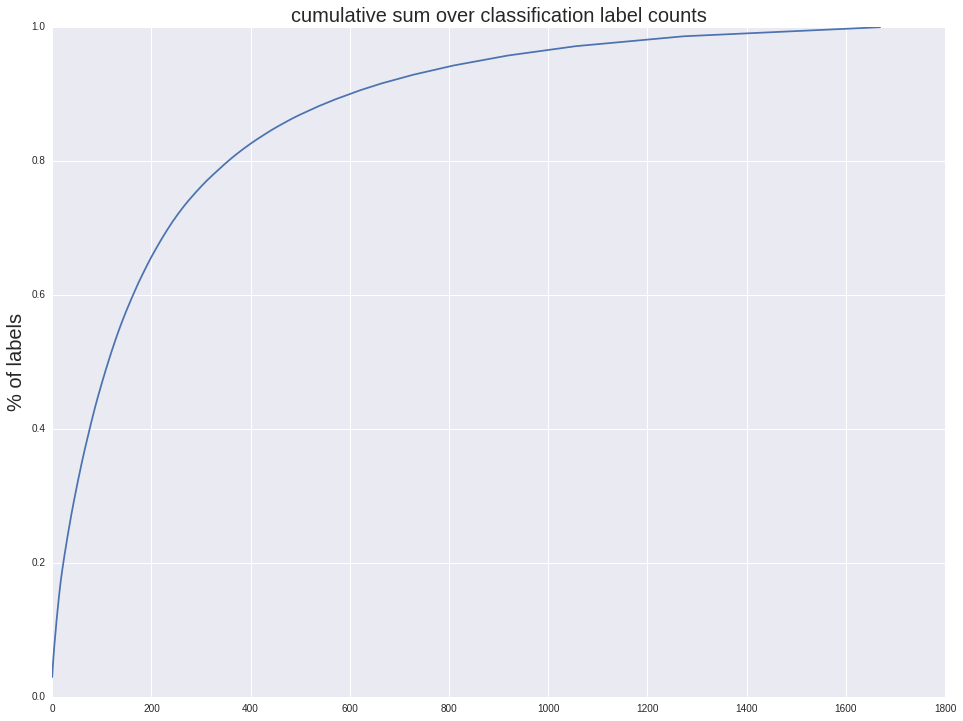

In [4]:
grouped = pd.DataFrame(all_classifications.groupby('classification')['classification'].agg('count'))
grouped.columns = ['count']
grouped = grouped.sort_values('count', ascending=False)
plt.figure(figsize=(16,12))
plt.title('cumulative sum over classification label counts', fontsize=20)
plt.plot(1.0 * grouped['count'].cumsum().values / grouped['count'].sum())
plt.ylabel('% of labels', fontsize=20)

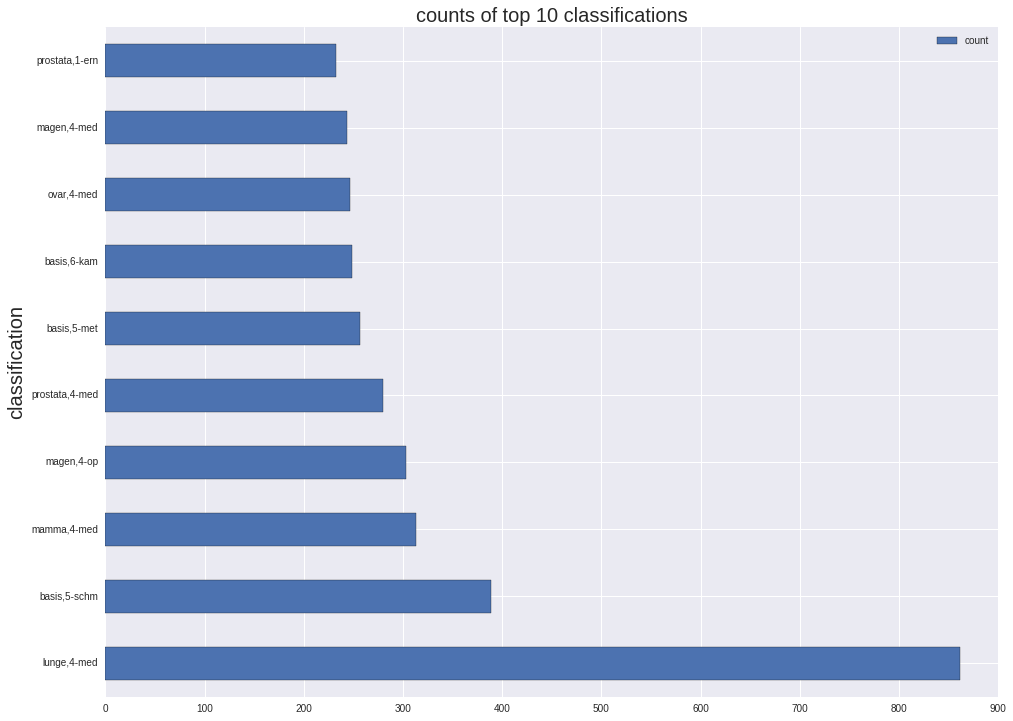

In [5]:
grouped[0:10].plot.barh(figsize=(16,12))
plt.title('counts of top 10 classifications', fontsize=20)
plt.ylabel('classification',  fontsize=20)

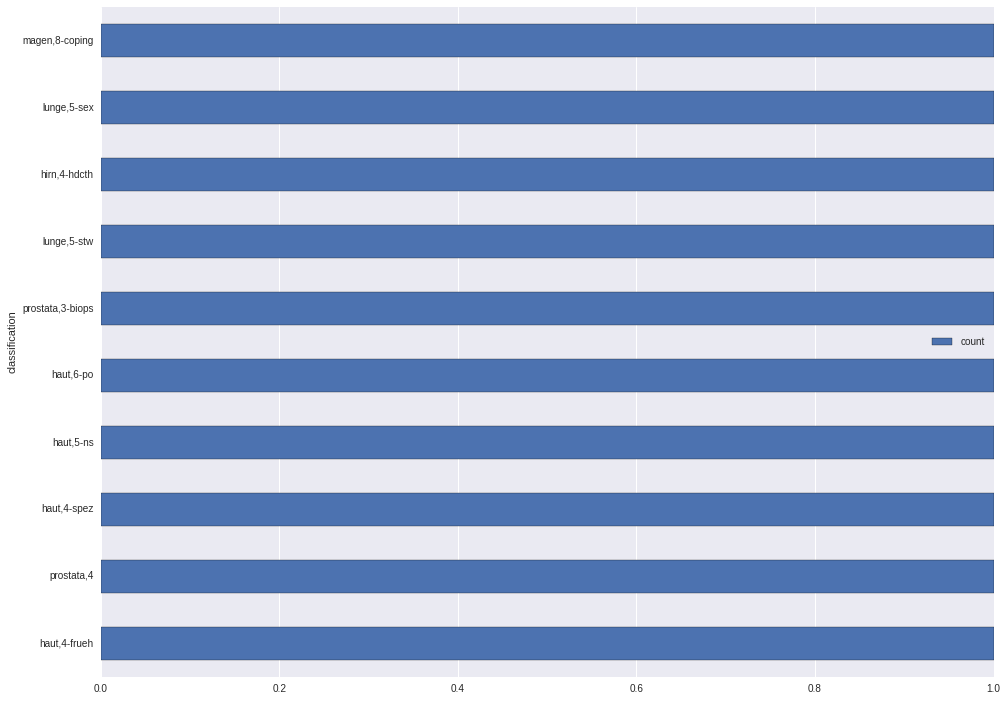

In [6]:
grouped[-10:].plot.barh(figsize=(16,12))
# plt.title('counts of top 10 classifications', fontsize=20)
# plt.ylabel('classification',  fontsize=20)

In [7]:
def truncate_classifications(row):
    return map(lambda r: r.replace("'", ""), row.split("',"))

def keep_only_top(orig_list, top_classifications):
    return np.intersect1d(orig_list, top_classifications)

def clean_classifications_and_truncate(df, top_classifications):
    from cleaning_classification_labels import clean_labels
    df['mapped_classification'] = clean_labels.clean_classification(df.classifications.fillna(""), '../data/master/information/translations-labels.csv', 'cleaning_classification_labels/classification_dictionary.csv')
    df['mapped_classification_list'] = df.classifications.str.replace('[\[\]]',"").apply(truncate_classifications)
    df['mapped_classification_list_truncated'] = df['mapped_classification_list'].apply(lambda r: keep_only_top(r, top_classifications))
    return df

def top_labels_from(df):
    from cleaning_classification_labels import clean_labels
    import itertools
    all_classifications = list(itertools.chain(*clean_labels.clean_classification(df.classifications.fillna(""), '../data/master/information/translations-labels.csv', 'cleaning_classification_labels/classification_dictionary.csv')))
    all_classifications = pd.DataFrame({'classification': all_classifications})
    grouped = pd.DataFrame(all_classifications.groupby('classification')['classification'].agg('count'))
    grouped.columns = ['count']
    grouped = grouped.sort_values('count', ascending=False)
    # capture ~82% of most common labels
    return list(grouped[0:400].index)


cleaned = clean_classifications_and_truncate(df, top_labels_from(df)).head(150)
cleaned.head()

,num,record-number,filename,pdfismissing,author,fulltitle,subtitle,pages,volume,number,...,useful,review_article,not_allowed_in_germany,year,abstract,pub-location,publisher,mapped_classification,mapped_classification_list,mapped_classification_list_truncated
0,1,6667,,0,[],Prolongation of the disease-free interval in s...,The New England journal of medicine,1465-1472,312,6667_1985,...,0,0,[],1985,To assess the effects of postoperative radiati...,,,[],[],[]
1,2,6668,6668_1990.pdf,0,[],NIH consensus conference. Adjuvant therapy for...,JAMA,1444-1450,264,6668_1990,...,0,0,[],1990,,,,[],[],[]
2,3,19866,,0,[],American College of Sports Medicine position s...,Medicine and Science in Sports and Exercise,265-274,22,19866_1990,...,1,0,[],1990,"The combination of frequency, intensity, and d...",,,"[basis,6-bew]","[basis,6-bew]","[basis,6-bew]"
3,4,22005,22005_1993.pdf,0,[],A predictive model for aggressive non-Hodgkin'...,N.Engl.J.Med.,987-994,329,22005_1993,...,0,0,[],1993,BACKGROUND: Although many patients with interm...,,,[],[],[]
4,5,2050,,0,"['Hermanek,P.','Marzoli,G.P.']",Lokale Therapie des Rektumkarzinoms. Verfahren...,,-,,2050_hermanek1994,...,0,0,[],1994,,Berlin Heidelberg Ney York Tokyo,Springer,[],[],[]


In [8]:
cleaned['len_orig'] = cleaned.mapped_classification_list.apply(lambda r: len(r))
cleaned['len_truncated'] = cleaned.mapped_classification_list_truncated.apply(lambda r: len(r))

/home/ppschmidt/venv/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/ppschmidt/venv/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [11]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import HashingVectorizer, CountVectorizer, TfidfVectorizer
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import hamming_loss, accuracy_score,precision_score,recall_score,f1_score
from scipy.sparse import hstack
import warnings,json,gzip
from sklearn.preprocessing import OneHotEncoder


def classify_cancer(fn, penalty, alpha):
    '''
    Runs a multilabel classification experiment
    '''
    X,y,labelNames = getFeaturesAndLabelsFine(fn)
    print X.shape, y.shape, len(labelNames)
    # a train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    # turn off warnings, usually there are some labels missing in the training set
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        # train a classifier
        print("Training classifier")
        classif = OneVsRestClassifier(SGDClassifier(penalty=penalty, alpha=alpha), n_jobs=-1).fit(X_train, y_train)
    # predict
    y_predicted = classif.predict(X_test)
    # the scores we want to compute
    scorers = [precision_score,recall_score,f1_score]
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        # compute Scores
        metrics = {s.__name__:getSortedMetrics(y_test,y_predicted,labelNames,s) for s in scorers}
    # dump results
#     json.dump(metrics,gzip.open("multilabel_classification_metrics.json","wt"))
#     hl = hamming_loss(y_test,y_predicted)
#     ps = precision_score(y_test, y_predicted, average='samples')
#     rs = recall_score(y_test, y_predicted, average='samples')
#     return hl, ps, rs
    return metrics

# medicinal database indicators
def indicator_for(row):
    words = ['medline', 'pubmed', 'embase', 'cochrane', 'cochrane library', 'ovid', 'google scholar']
    return [1.0 if row['review_article'] == 1 and word.lower() in row.abstract.lower().split(" ") else 0.0 for word in words]

def indicator_count_for(row):
    words = ['medline', 'pubmed', 'embase', 'cochrane', 'cochrane library', 'ovid', 'google scholar']
    return np.sum([1.0 if row['review_article'] == 1 and word.lower() in row.abstract.lower().split(" ") else 0.0 for word in words])

def one_hot_database_indicators_from(df):
    return OneHotEncoder().fit_transform(df.fillna("").apply(indicator_count_for, axis=1).values.reshape(-1, 1))

def getFeatures(fn):
    '''
    Load and vectorize features
    '''
    df = pd.read_csv(fn)
    features = []
    print("Vectorizing title character ngrams")
    titleVectorizer = HashingVectorizer(analyzer="char_wb",ngram_range=(1,4),n_features=2**12)
    features.append(titleVectorizer.fit_transform(df.fulltitle.fillna("")))
    print("Vectorizing keywords")
    # searchquery_terms is already a preprocessing step done by data angels, for direct integration
    # keywords seems to be better
    #features.append(CountVectorizer().fit_transform(df.searchquery_terms.str.replace('[\[\]\'\"]',"")))
    # take original keywords as per search query
    features.append(CountVectorizer().fit_transform(df.keywords.str.replace('[\[\]\'\"]',"")))
    print("Vectorizing authors")
    features.append(HashingVectorizer(n_features=2**12).fit_transform(df.author.fillna("").str.replace('[\[\]\'\"]',"")))
    print("Vectorizing abstracts")
    features.append(HashingVectorizer(n_features=2**12).fit_transform(df.abstract.fillna("").str.replace('[\[\]\'\"]',"")))
    print("Computing medicinal database counts")
    features.append(one_hot_database_indicators_from(df))
    X = hstack(features)
    print("Extracted feature vectors with %d dimensions"%X.shape[-1])
    return X

def getFeaturesAndLabelsFineMapped(fn):
    '''
    TODO
    Load and vectorizer features and fine grained labels (vectorized using MultiLabelBinarizer)
    Before piping through MultiLabelBinarizer, apply mapping to reduce the cardinality of labels
    '''
    print("Reading data")
    df = pd.read_csv(fn)
    # tokenize and binarize cancer classification labels
    print("Vectorizing labels")
    labelVectorizer = MultiLabelBinarizer()
    # old, uncleaned 
    #y = labelVectorizer.fit_transform(df.classifications.str.replace('[\[\]\'\"]',"").apply(tokenizeCancerLabels))
    cleaned = clean_classifications_and_truncate(df, top_labels_from(df))['mapped_classification_list_truncated']
    y = labelVectorizer.fit_transform(cleaned)
    print("Vectorized %d labels"%y.shape[-1])
    X = getFeatures(fn)
    return X,y,labelVectorizer.classes_

def getFeaturesAndLabelsFine(fn):
    '''
    Load and vectorizer features and fine grained labels (vectorized using MultiLabelBinarizer)
    '''
    print("Reading data")
    df = pd.read_csv(fn).fillna("")
    # tokenize and binarize cancer classification labels
    print("Vectorizing labels")
    labelVectorizer = MultiLabelBinarizer()
    #y = labelVectorizer.fit_transform(df.classifications.str.replace('[\[\]\'\"]',"").apply(tokenizeCancerLabels))
    # get ~80% most common labels, filter out all remaining ones
    top = top_labels_from(df)
    trunc = clean_classifications_and_truncate(df, top).mapped_classification_list_truncated
    y = labelVectorizer.fit_transform(trunc)
    print("Vectorized %d labels"%y.shape[-1])
    X = getFeatures(fn)
    return X,y,labelVectorizer.classes_

def getFeaturesAndLabelsCoarse(fn):
    '''
    Load and vectorizer features and coarse grained top level labels (vectorized using MultiLabelBinarizer)
    '''
    print("Reading data")
    df = pd.read_csv(fn)
    # tokenize and binarize cancer classification labels
    print("Vectorizing labels")
    labelVectorizer = MultiLabelBinarizer()
    y = labelVectorizer.fit_transform(df.label_top_level.str.replace('[\[\]\'\"]',"").apply(tokenizeCancerLabels))
    print("Vectorized %d labels"%y.shape[-1])
    X = getFeatures(fn)
    return X,y,labelVectorizer.classes_

def getSortedMetrics(true, predicted, labels, scorer):
    '''
    Scores predictions
    '''
    score = scorer(true,predicted,average=None)
    return [(labels[l],score[l]) for l in score.argsort()[::-1]]


def tokenizeCancerLabels(s):
    '''
    Tokenize the label string and remove empty strings
    '''
    return [t for t in s.split(",") if len(t)>0]


In [12]:
classify_cancer('../data/master/features/features.csv', penalty='l2', alpha=0.0001)
# test = pd.read_csv('../data/master/features/features.csv').fillna("")
# print("Vectorizing labels")
# labelVectorizer = MultiLabelBinarizer()
#y = labelVectorizer.fit_transform(df.classifications.str.replace('[\[\]\'\"]',"").apply(tokenizeCancerLabels))

# from cleaning_classification_labels import clean_labels
# df['mapped_classification'] = clean_labels.clean_classification(df.classifications.fillna(""), '../data/master/information/translations-labels.csv', 'cleaning_classification_labels/classification_dictionary.csv')
# from cleaning_classification_labels import clean_labels
# top_labels_from(clean_labels.clean_classification(test, '../data/master/information/translations-labels.csv', 'cleaning_classification_labels/classification_dictionary.csv'))
# y = labelVectorizer.fit_transform(test.clean_labels.cleaning_classification_labels(test.classifications.fillna(""), '../data/master/information/translations-labels.csv', 'cleaning_classification_labels/classification_dictionary.csv'))
# print("Vectorized %d labels"%y.shape[-1])
# top = top_labels_from(test)
# trunc = clean_classifications_and_truncate(test, top).mapped_classification_list_truncated
# labelVectorizer.fit_transform(trunc).shape

Reading data
Vectorizing labels
Vectorized 345 labels
Vectorizing title character ngrams
Vectorizing keywords
Vectorizing authors
Vectorizing abstracts
Computing medicinal database counts
Extracted feature vectors with 12397 dimensions
(45885, 12397) (45885, 345) 345
Training classifier


{'f1_score': [('magen,4-op', 0.67326732673267309),
  ('lunge,3-screen', 0.54545454545454541),
  ('basis,5-ue', 0.52631578947368418),
  ('zervix,3-screen', 0.43902439024390238),
  ('niere,4-op', 0.43478260869565216),
  ('basis,5-thromb', 0.36363636363636359),
  ('pankreas,4-op', 0.35000000000000003),
  ('pankreas,3-biops', 0.26666666666666672),
  ('prostata,3-screen', 0.21428571428571427),
  ('magen,1-med', 0.2105263157894737),
  ('basis,6-po', 0.20547945205479454),
  ('harn,4-progn', 0.19999999999999998),
  ('basis,6-bew', 0.19512195121951217),
  ('ovar,4-and', 0.16666666666666669),
  ('oesophagus,1-med', 0.15384615384615385),
  ('basis,8-angeh', 0.13333333333333333),
  ('melanom,4-progn', 0.13333333333333333),
  ('basis,5-kach', 0.125),
  ('harn,1-med', 0.125),
  ('basis,6-begl-med', 0.1176470588235294),
  ('oesophagus,4-progn', 0.10526315789473684),
  ('prostata,8-lq', 0.083333333333333329),
  ('prostata,4-progn', 0.051282051282051287),
  ('basis,5-fat', 0.048780487804878057),
  ('hi

# data cleanup

In [ ]:
def correct_data(path="master/features/"):

    def is_hoden_niere(x):
        return "hoden" in x or "niere" in x

    data = pd.read_csv(path+"features.csv")
    correct_label = pd.read_csv(path+"features-hodenniere.csv").drop_duplicates(["pages","fulltitle"])
    c_data = pd.merge(data,correct_label,on=["fulltitle","pages"],how='left')
    c_data["useful"] = data.useful.values
    is_hoden_niere = c_data["cancer_types_x"].apply(is_hoden_niere)
    data["useful"] = c_data.useful.values

    return data


# word stemming

In [ ]:
def pre_process_word_stemmer(x,type_x='porter'):

    if type_x not in ['porter','lancaster','snowball']:
        return x
    words = x.split(" ")
    if type_x == 'porter':
        stemmer =  nltk.stem.PorterStemmer()
    elif type_x == 'lancaster':
        stemmer = nltk.stem.LancasterStemmer()
    elif type_x == 'snowball':
        stemmer = nltk.stem.SnowballStemmer(language='english')
    #print words
    return ' '.join([stemmer.stem(w) for w in words])

pre_process_word_stemmer('cancers type full',type_x='porter')

# model selection

In [ ]:
precisions = []
alphas = [1e-3, 1e-2, 1e-1]
for a in alphas:
    _, ps, _, = classify_cancer('../data/master/features/features.csv', penalty='l2', alpha=a)
    print "alpha: {}, p: {}".format(a, ps)
    precisions.append(ps)

In [ ]:
import pandas as pd
import numpy as np

#path_for_translation_labels = 'cancer_data/information/translations-labels.csv'   #path of the .csv translation file provided by the data ambassadors
#path_for_manual_transtable = 'classification_dictionary.csv'        # path of the .csv file   that was filled manually by Marie

def clean_classification(class_series, trans_path, manual_trans_path):

    brac_free = class_series.apply(tokenizeCancerLabels)
    
    trans_labels_df = pd.read_csv(trans_path,delimiter=';')

    labels1st = np.unique(trans_labels_df['Label (1st Level)'])

    class_trans_df = pd.read_csv(manual_trans_path,delimiter=';',header=None)

    #### create dictionary that translates to correct first level 
    include_1st_level_dict = {'1-bew': '1-koerper', 
                              '1-gew': '1-koerper',
                              '1-gen': '1-koerper', 
                              '1-horm':'1-koerper',
                              '1-rauch': '1-ps', 
                              '1-alk': '1-ps', 
                              '1-canna': '1-ps',
                              '1-diab': '1-erk',
                              '1-infekt': '1-erk', 
                              '3-tu-marker': '3-lab',
                              '3-biops': '3-lab',
                               '5-fr\xc3\xbch': '5'}

    for label in labels1st:
        include_1st_level_dict[label] = label

    for i in range(class_trans_df.shape[0]):
        cc = class_trans_df.iloc[i]        
        include_1st_level_dict[cc[0]] = cc[1]

    ## done creating the dictionary
    cleaned_series = brac_free.apply(lambda x: clean_levels(x,include_1st_level_dict))

    return cleaned_series


def tokenizeCancerLabels(s):
    '''
    Tokenize the label string and remove empty strings
    '''
    ## if string is an empty list return an empty list
    if s == '[]':
        return []

    ## else return list with    bodypart,classify
    s = s.replace("['","").replace("']","")
    return [t for t in s.split("','") if len(t)>0]



def clean_levels(s_list,trans_dict):
    '''
    function that cleans the label
    '''
    new_list = []
    ## check if there is an entry
    if len(s_list) == 0:
        return new_list
        
    for t in s_list:        
        ts = t.split(',')
        if len(ts) > 2:  ## here cancer applies to more than one bodyparts.. sort them alphabetically
            bodystring = ','.join(sorted(map(lambda x: x.lower(),ts[:-1])))        
            old_class = ts[-1]                        
        else:   #otherwise there is only one bodypart
            bodypart = ts[0]
            old_class = ts[1]
            
        ### correct the classification of the label of format  X-str-...
        ocs = old_class.split('-')
        
        if len(ocs) == 1:
            new_class = old_class
            
        elif len(ocs) == 2:
            if trans_dict.has_key(old_class):
                new_class = trans_dict[old_class]
            else:
                new_class = old_class

        elif len(ocs) > 2:
            first = ocs[0] + '-' + ocs[1]            
            first_extended = ocs[0] + '-' + ocs[1] + '-' + ocs[2]  ## need extra check as '3-tu-marker ' should be maped to  '3-labl

            if trans_dict.has_key('-'.join(ocs)):
                new_class = trans_dict['-'.join(ocs)]
            elif trans_dict.has_key(first_extended):
                new_class = trans_dict[first_extended]
            elif trans_dict.has_key(first):
                new_class = trans_dict[first]
            else:
                new_class = old_class
                    
        new_list.append(ts[0] + ',' + new_class)

    return new_list


In [ ]:
pd.set_option('display.max_colwidth', -1)
from cleaning_classification_labels import clean_labels
df = pd.read_csv('../data/master/features/features.csv').fillna("")
df['cleaned_classifications'] = clean_labels.clean_classification(df.classifications, '../data/master/information/translations-labels.csv', 'cleaning_classification_labels/classification_dictionary.csv')
df[['cleaned_classifications', 'classifications']].head(150)
# clean_classification(df, '../data/master/information/translations-labels.csv', 'cleaning_classification_labels/classification_dictionary.csv')

In [ ]:
pd.DataFramepd.DataFrame({'alpha': alphas, 'precision': precisions}).set_index('alpha')
perf.plot()